In [1]:
import pandas as pd

# Housekeeping: find out what is the current directory and adjust the path to the data file
# import os
# cwd = os.getcwd()
# print ('working_directory = ' + cwd)

# load data into the pandas dataframe (df)
df = pd.read_csv("imdb_100.csv")

# get sense of a data in the df by extracting 5 rows
df.head()

,star_rating,title,year,content_rating,genre,duration,gross
0,9.3,The Shawshank Redemption,1994,R,Drama,142,1963330
1,9.2,The Godfather,1972,R,Crime,175,28341469
2,9.0,The Dark Knight,2008,PG-13,Action,152,1344258
3,9.0,The Godfather: Part II,1974,R,Crime,202,134966411
4,8.9,Pulp Fiction,1994,R,Crime,154,1935047


In [6]:
# API key helpers

def get_api_key():
    """
    This function reads the first line in the config.txt file and returns as an API key.
    Since it is a bad software engineering practice to expose the key in the code, the key is stored in the file
    """
    api_key=''
    with open('config.txt') as f:
        api_key = f.readline()
    if len(api_key) == 0:
        raise Exception("please configure OMDB API key in the config.txt file")    
    return api_key

api_key=get_api_key()

In [7]:
# helper functions and objects to represent movies and convert the OMDB data

def extract_rt_rating_percent(movie, ratings):
    """
    Takes a list of Rating objects {"Source": ..., "Value": ...} from the 'Ratings' porition of the OMDB result,
    Finds the rating that matches to the 'Roten Tomatoes' as a source (the comparison is case-insensitive)
    Assumes format '<float>%' (% sign is optional), if the <float> cannot be parsed, an error message is printed and None is returned
    """
    for rating in ratings:
        # print ('Source = {}, Value = {}'.format(rating['Source'], rating['Value']))
        result = None
        if rating['Source'].lower() == 'Rotten Tomatoes'.lower():
            try:
                return float(rating['Value'].replace('%', ''))
            except:
                print ('Unable to extract Roten Tomatoes rating for movie ' + str(movie))
    return result

def extract_imdb_rating_percent(movie, ratings):
    """
    Takes a list of Rating objects {"Source": ..., "Value": ...} from the 'Ratings' porition of the OMDB result,
    Finds the rating that matches to the 'Internet Movie Database' as a source (the comparison of the Source is case-insensitive)
    Calculates the percentage of the rating, i.e 8.9/10 = 89
    Assumes format '<int>/<int>' if it cannot be parsed, an error message is printed and None is returned
    """
    for rating in ratings:
        # print ('Source = {}, Value = {}'.format(rating['Source'], rating['Value']))
        result = None
        if rating['Source'].lower() == 'Internet Movie Database'.lower():
            try:
                parts = rating['Value'].split('/')
                if len(parts) != 2:
                    print ('Cannot parse IMDB rating [{}], expected "<int>/<int>"'.format(rating['Value']))
                else:
                    nom = float(parts[0]) * 100
                    denom = float(parts[1])
                    return nom / denom
            except:
                print ('Unable to extract Roten Tomatoes rating for movie ' + str(movie))
    return result


def value_or_default(value, default):
    return default if value is None else value

class Movie:
    """
    A movie represents a Movie object that is constructed from the OMDB JSON
    """
    def __init__(self, *args, **kwargs):
        # Title
        if 'Title' in kwargs:
            self.title = kwargs['Title']
        else:
            print ('Unable to extract title for movie ' + str(self))
            self.title = None
            return
        # Year
        try:
            self.year = int(kwargs['Year'])
        except:
            print ('Unable to extract year for movie ' + str(self))
            self.year = None
            return
        # Genre            
        if 'Genre' in kwargs:
            self.genre = kwargs['Genre']
        else:
            print ('Unable to extract genre for movie ' + str(self))
            self.genre = None
            return
        # Ratings
        if 'Ratings' in kwargs:
            self.rt_rating_percent = extract_rt_rating_percent(self, kwargs['Ratings'])
            self.imdb_rating_percent = extract_imdb_rating_percent(self, kwargs['Ratings'])
        else:
            print ('Unable to extract Ratings for movie ' + str(self))
            return
    
    def __repr__(self):
        return 'Movie[title={}, year={}, genre={}, rt_rating_percent={}]'.format(
            value_or_default(self.title, None) if hasattr(self, 'title') else None,
            value_or_default(self.year, None) if hasattr(self, 'year') else None,
            value_or_default(self.genre, None) if hasattr(self, 'genre') else None,
            value_or_default(self.rt_rating_percent, None) if hasattr(self, 'rt_rating_percent') else None,
            value_or_default(self.imdb_rating_percent, None) if hasattr(self, 'imdb_rating_percent') else None
        )

In [8]:
# debugging slot, please ignore

json_example = """{
  "Title": "Pulp Fiction",
  "Year": "1994",
  "Rated": "R",
  "Released": "14 Oct 1994",
  "Runtime": "154 min",
  "Genre": "Crime, Drama",
  "Director": "Quentin Tarantino",
  "Writer": "Quentin Tarantino (stories), Roger Avary (stories), Quentin Tarantino",
  "Actors": "Tim Roth, Amanda Plummer, Laura Lovelace, John Travolta",
  "Plot": "The lives of two mob hitmen, a boxer, a gangster and his wife, and a pair of diner bandits intertwine in four tales of violence and redemption.",
  "Language": "English, Spanish, French",
  "Country": "USA",
  "Awards": "Won 1 Oscar. Another 69 wins & 75 nominations.",
  "Poster": "https://m.media-amazon.com/images/M/MV5BNGNhMDIzZTUtNTBlZi00MTRlLWFjM2ItYzViMjE3YzI5MjljXkEyXkFqcGdeQXVyNzkwMjQ5NzM@._V1_SX300.jpg",
  "Ratings": [
    {
      "Source": "Internet Movie Database",
      "Value": "8.9/10"
    },
    {
      "Source": "Rotten tomatoes",
      "Value": "92%"
    },
    {
      "Source": "Metacritic",
      "Value": "94/100"
    }
  ],
  "Metascore": "94",
  "imdbRating": "8.9",
  "imdbVotes": "1,831,004",
  "imdbID": "tt0110912",
  "Type": "movie",
  "DVD": "21 Apr 2016",
  "BoxOffice": "$107,928,762",
  "Production": "Miramax Films*, A Band Apart, Jersey Films",
  "Website": "N/A",
  "Response": "True"
}"""

json_example2="""
{
  "Title": "The Silence of the Lambs",
  "Year": "1991",
  "Rated": "R",
  "Released": "14 Feb 1991",
  "Runtime": "118 min",
  "Genre": "Crime, Drama, Thriller",
  "Director": "Jonathan Demme",
  "Writer": "Thomas Harris (based on the novel by), Ted Tally (screenplay by)",
  "Actors": "Jodie Foster, Lawrence A. Bonney, Kasi Lemmons, Lawrence T. Wrentz",
  "Plot": "A young F.B.I. cadet must receive the help of an incarcerated and manipulative cannibal killer to help catch another serial killer, a madman who skins his victims.",
  "Language": "English, Latin",
  "Country": "USA",
  "Awards": "Won 5 Oscars. Another 63 wins & 51 nominations.",
  "Poster": "https://m.media-amazon.com/images/M/MV5BNjNhZTk0ZmEtNjJhMi00YzFlLWE1MmEtYzM1M2ZmMGMwMTU4XkEyXkFqcGdeQXVyNjU0OTQ0OTY@._V1_SX300.jpg",
  "Ratings": [
    {
      "Source": "Internet Movie Database",
      "Value": "8.6/10"
    },
    {
      "Source": "Rotten Tomatoes",
      "Value": "96%"
    },
    {
      "Source": "Metacritic",
      "Value": "85/100"
    }
  ],
  "Metascore": "85",
  "imdbRating": "8.6",
  "imdbVotes": "1,274,200",
  "imdbID": "tt0102926",
  "Type": "movie",
  "DVD": "27 Aug 2015",
  "BoxOffice": "$130,742,922",
  "Production": "Orion Pictures",
  "Website": "N/A",
  "Response": "True"
}
"""

import json
j = json.loads(json_example2)
movie = Movie(**j)

from pprint import pprint
pprint(vars(movie))

{'genre': 'Crime, Drama, Thriller',
 'imdb_rating_percent': 86.0,
 'rt_rating_percent': 96.0,
 'title': 'The Silence of the Lambs',
 'year': 1991}


In [9]:
# Your script should pull the Rotten Tomato score for each of the movies in the top 100 IMDB movies and join it onto your Pandas dataframe. You may need to clean up the data!

import urllib
import requests
import json

omdb_url = 'http://www.omdbapi.com/?apikey={}&t={}&y={}&r=json'

"""
Loop through the rows of the dataframe and issue a request against the OMDB API
The result json is convered into an object which are then converted into another padas dataframe
"""
movies = []
for index, row in df.iterrows():
    ready_url = omdb_url.format(api_key, urllib.parse.quote(row.title), row.year)
    receive = requests.get(ready_url)
    received_json = json.loads(receive.content)
    movie = Movie(**received_json)
    if movie.title is not None and movie.year is not None and movie.rt_rating_percent is not None and movie.imdb_rating_percent is not None:
        movies.append(movie)
        print('PROCESSED movie [{}] through url [{}]'.format(index, ready_url))
    else:
        print('IGNORED movie [{}] through url [{}]'.format(index, ready_url))

PROCESSED movie [0] through url [http://www.omdbapi.com/?apikey=88ea10cd&t=The%20Shawshank%20Redemption&y=1994&r=json]
PROCESSED movie [1] through url [http://www.omdbapi.com/?apikey=88ea10cd&t=The%20Godfather&y=1972&r=json]
PROCESSED movie [2] through url [http://www.omdbapi.com/?apikey=88ea10cd&t=The%20Dark%20Knight&y=2008&r=json]
PROCESSED movie [3] through url [http://www.omdbapi.com/?apikey=88ea10cd&t=The%20Godfather%3A%20Part%20II&y=1974&r=json]
PROCESSED movie [4] through url [http://www.omdbapi.com/?apikey=88ea10cd&t=Pulp%20Fiction&y=1994&r=json]
PROCESSED movie [5] through url [http://www.omdbapi.com/?apikey=88ea10cd&t=Schindler%27s%20List&y=1993&r=json]
PROCESSED movie [6] through url [http://www.omdbapi.com/?apikey=88ea10cd&t=The%20Lord%20of%20the%20Rings%3A%20The%20Return%20of%20the%20King&y=2003&r=json]
PROCESSED movie [7] through url [http://www.omdbapi.com/?apikey=88ea10cd&t=The%20Good%2C%20the%20Bad%20and%20the%20Ugly&y=1966&r=json]
PROCESSED movie [8] through url [http

In [10]:
# convert the list of the collected movies into the panda's dataframe

data = list(map(lambda movie: [movie.title, movie.genre, movie.year, movie.rt_rating_percent, movie.imdb_rating_percent], movies))

omdb_df = pd.DataFrame(data, columns = ['title', 'genre', 'year', 'rt_rating_percent', 'imdb_rating_percent']) 

omdb_df.head(12)

,title,genre,year,rt_rating_percent,imdb_rating_percent
0,The Shawshank Redemption,Drama,1994,91.0,93.0
1,The Godfather,"Crime, Drama",1972,98.0,92.0
2,The Dark Knight,"Action, Crime, Drama, Thriller",2008,94.0,90.0
3,The Godfather: Part II,"Crime, Drama",1974,98.0,90.0
4,Pulp Fiction,"Crime, Drama",1994,92.0,89.0
5,Schindler's List,"Biography, Drama, History",1993,97.0,89.0
6,The Lord of the Rings: The Return of the King,"Action, Adventure, Drama, Fantasy",2003,93.0,89.0
7,"The Good, the Bad and the Ugly",Western,1966,97.0,88.0
8,12 Angry Men,"Crime, Drama",1957,100.0,90.0
9,Avengers: Infinity War,"Action, Adventure, Sci-Fi",2018,85.0,84.0


In [11]:
# Your script should pull the Rotten Tomato score for each of the movies in the top 100 IMDB movies and join it onto your Pandas dataframe.
# You may need to clean up the data!

# Note: the data has been cleaned up at the time when loaded from the OMDB API

# merge original dataframe with the one obtained from the omdb by using the 'title' and the 'year' columns
# note: this is the inner join, i.e. the rows will not be included if there is no match

df_merged = pd.merge(df, omdb_df, on=['title', 'year'])

df_merged.head()

,star_rating,title,year,content_rating,genre_x,duration,gross,genre_y,rt_rating_percent,imdb_rating_percent
0,9.3,The Shawshank Redemption,1994,R,Drama,142,1963330,Drama,91.0,93.0
1,9.2,The Godfather,1972,R,Crime,175,28341469,"Crime, Drama",98.0,92.0
2,9.0,The Dark Knight,2008,PG-13,Action,152,1344258,"Action, Crime, Drama, Thriller",94.0,90.0
3,9.0,The Godfather: Part II,1974,R,Crime,202,134966411,"Crime, Drama",98.0,90.0
4,8.9,Pulp Fiction,1994,R,Crime,154,1935047,"Crime, Drama",92.0,89.0


In [12]:
# What are the top five R-Rated movies?

# top 5 TomatoRoten-Rated movies is found by using 'nlargest' function on the merged dataframe

df_merged.nlargest(5, 'rt_rating_percent')

,star_rating,title,year,content_rating,genre_x,duration,gross,genre_y,rt_rating_percent,imdb_rating_percent
8,8.9,12 Angry Men,1957,Approved,Crime,96,1535170,"Crime, Drama",100.0,90.0
19,8.7,Seven Samurai,1954,Not Rated,Adventure,207,1418566,"Action, Adventure, Drama",100.0,86.0
52,8.5,Modern Times,1936,G,Comedy,87,510702,"Comedy, Drama, Family, Romance",100.0,85.0
62,8.4,3 Idiots,2009,PG-13,Comedy,170,1136687,"Comedy, Drama",100.0,84.0
64,8.4,Citizen Kane,1941,R,Drama,119,554499,"Drama, Mystery",100.0,83.0


In [13]:
# What is the average Rotten Tomato score for the top 100 IMDB films

# mean of a column is calculated by using the 'mean' on the column of interest ('rt_rating_percent' in our case)

df_merged.rt_rating_percent.mean()

91.07777777777778

In [14]:
# What is the Five Number Summary like for top rated films as per IMDB? Is it skewed?

# The 'Five Number Summary' (and a bit more stats) are extrated by the 'describe()' function
# It is skewed towards the higher rating due to the fact that the dataset is based on top 100 movies from IMDB

df_merged.rt_rating_percent.describe()

count     90.000000
mean      91.077778
std        7.354931
min       71.000000
25%       87.000000
50%       93.000000
75%       97.000000
max      100.000000
Name: rt_rating_percent, dtype: float64

In [15]:
# Create a column that is the ratio between Rotten Tomato rating vs IMDB rating. What film has the highest IMDB : Rotten Tomato ratio? The lowest?

# a new column representing ratio between imdb/rt rating

df_merged['imdb_over_rt'] = df_merged.imdb_rating_percent / df_merged.rt_rating_percent

df_merged.head()

,star_rating,title,year,content_rating,genre_x,duration,gross,genre_y,rt_rating_percent,imdb_rating_percent,imdb_over_rt
0,9.3,The Shawshank Redemption,1994,R,Drama,142,1963330,Drama,91.0,93.0,1.021978
1,9.2,The Godfather,1972,R,Crime,175,28341469,"Crime, Drama",98.0,92.0,0.938776
2,9.0,The Dark Knight,2008,PG-13,Action,152,1344258,"Action, Crime, Drama, Thriller",94.0,90.0,0.957447
3,9.0,The Godfather: Part II,1974,R,Crime,202,134966411,"Crime, Drama",98.0,90.0,0.918367
4,8.9,Pulp Fiction,1994,R,Crime,154,1935047,"Crime, Drama",92.0,89.0,0.967391


In [16]:
# Create a column that is the ratio between Rotten Tomato rating vs IMDB rating. What film has the highest IMDB : Rotten Tomato ratio? The lowest?

# the movie with the maximum imdb_over_rt value

df_merged.iloc[df_merged.imdb_over_rt.idxmax()]

star_rating                       8.8
title                    Forrest Gump
year                             1994
content_rating                  PG-13
genre_x                         Drama
duration                          142
gross                         1401164
genre_y                Drama, Romance
rt_rating_percent                71.0
imdb_rating_percent              88.0
imdb_over_rt                 1.239437
Name: 12, dtype: object

In [17]:
# Create a column that is the ratio between Rotten Tomato rating vs IMDB rating. What film has the highest IMDB : Rotten Tomato ratio? The lowest?

# the movie with the minimum imdb_over_rt value

df_merged.iloc[df_merged.imdb_over_rt.idxmin()]

star_rating                                        8.3
title                                L.A. Confidential
year                                              1997
content_rating                                       R
genre_x                                          Crime
duration                                           138
gross                                         13182281
genre_y                Crime, Drama, Mystery, Thriller
rt_rating_percent                                 99.0
imdb_rating_percent                               82.0
imdb_over_rt                                  0.828283
Name: 84, dtype: object

In [18]:
# Create your own question... then answer it! 
# What are the mean, variance and standard deviation of the rt rating for top 100 IMDB movies?

mean = df_merged.rt_rating_percent.mean(axis = 0)
std = df_merged.rt_rating_percent.std(axis = 0)
var = df_merged.rt_rating_percent.var()

print ('mean = {}, std = {}, var = {}'.format(mean, std, var))

mean = 91.07777777777778, std = 7.354930743535066, var = 54.09500624219727


/usr/local/google/home/tasyrkin/.pyenv/versions/3.9.1/lib/python3.9/site-packages/IPython/core/inputtransformer2.py:484: UserWarning: `make_tokens_by_line` received a list of lines which do not have lineending markers ('\n', '\r', '\r\n', '\x0b', '\x0c'), behavior will be unspecified
  warnings.warn("`make_tokens_by_line` received a list of lines which do not have lineending markers ('\\n', '\\r', '\\r\\n', '\\x0b', '\\x0c'), behavior will be unspecified")


Text(0, 0.5, 'frequency')

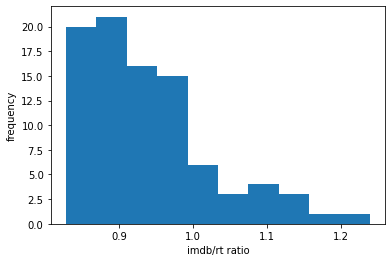

In [19]:
# What is the relationship between IMDB ratings and Rotten Tomato ratings?

# draw a single histogram of imdb_over_rt ratio to show that vast majority of the movies have lower IMDB rating than RT rating
# x axis represents the ratio
# y axis represetns the number of movies (frequency) of a specific ratio range

import matplotlib.pyplot as plt

plt.hist(df_merged.imdb_over_rt.tolist(), bins=10, label='imdb_rating') 
plt.xlabel('imdb/rt ratio')
plt.ylabel('frequency')

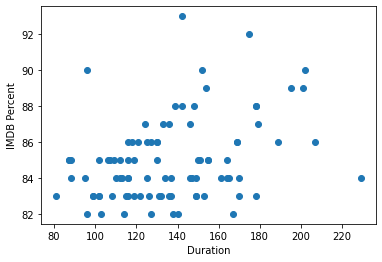

In [20]:
# What is the relationship between IMDB rating and movie duration?

# Longer movies tend to have higher IMDB rating (and vice versa)

import matplotlib.pyplot as plt

plt.scatter(df_merged.duration.tolist(), df_merged.imdb_rating_percent.tolist())
plt.xlabel('Duration')
plt.ylabel('IMDB Percent')
plt.show()

In [21]:
# How many movies are there in each category?

# not sure if there are clear categories in that respect

Text(0, 0.5, 'Frequency')

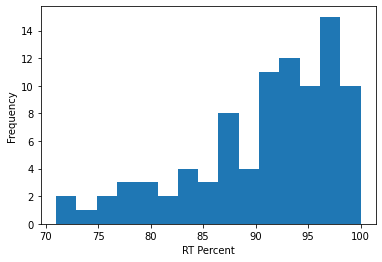

In [22]:
# What does the distribution of Rotten Tomato ratings look like?

# The distribution is skewed towards the higher rating due to the fact that top 100 IMDB movies are considered

import matplotlib.pyplot as plt

plt.hist(df_merged.rt_rating_percent.tolist(), bins=15, label='rt_rating') 
plt.xlabel('RT Percent')
plt.ylabel('Frequency')